# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах). 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv(r"./data/lenta_40k.csv.zip")

In [4]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [5]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

354611

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

24091

In [11]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MAX_LEN = 200

In [15]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [16]:
X.shape

(44356, 200)

In [17]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [18]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [19]:
len(label2id)

19

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

In [21]:
class MyShinyModel:

    MAX_LEN = 200

    def __init__(self, input_layer_dim: int, output_layer_dim: int):
        self.model: keras.Model = NotImplemented

    def summary(self):
        return self.model.summary()

    def fit(self, X_train, X_valid, y_train, y_valid):
        self.model.fit(
            X_train,
            y_train,
            validation_data=(
                X_valid,
                y_valid
            ),
            batch_size=2000,
            epochs=30
        )

    def plot(self):
        plt.plot(self.model.history.history['rec@prec'])
        plt.plot(self.model.history.history['val_rec@prec'])
        plt.title('model metrics')
        plt.ylabel('recall at precision')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def predict(self, X):
        return self.model.predict(X)

In [147]:
class RegularULMfit(MyShinyModel):

    def __init__(self, input_layer_dim: int, output_layer_dim: int):
        inputs = keras.layers.Input(shape=(self.MAX_LEN,))
        embeddings = keras.layers.Embedding(input_dim=input_layer_dim, output_dim=30)(inputs, )

        # layer_1 = keras.layers.SimpleRNN(128, return_sequences=True)(embeddings)
        layer_2 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
        layer_3 = keras.layers.LSTM(128, return_sequences=True)(layer_2)

        avg_pool = keras.layers.GlobalAveragePooling1D()(layer_3)
        max_pool = keras.layers.GlobalMaxPooling1D()(layer_3)

        ##  layer_3[весь батч, последний временной промежуток, все фичи]
        concat = keras.layers.concatenate((layer_3[:, -1, :], avg_pool, max_pool,))

        softmax_layer = keras.layers.Dense(output_layer_dim, activation='softmax')(concat)

        self.model = keras.Model(inputs=inputs, outputs=softmax_layer)
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                keras.metrics.RecallAtPrecision(0.8, name='rec@prec')
            ]
        )

In [148]:
regular_model = RegularULMfit(len(word2id), len(label2id))

In [149]:
regular_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 200, 30)   │    722,790 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 200, 128)  │     81,408 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 200, 128)  │    131,584 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 128)       │          0 │ lstm_9[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ lstm_9[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ lstm_9[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 384)       │          0 │ get_item_6[0][0], │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 19)        │      7,315 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 943,097 (3.60 MB)

 Trainable params: 943,097 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

In [150]:
regular_model.fit(X_train, X_valid, y_train, y_valid)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - loss: 2.7520 - rec@prec: 0.0000e+00 - val_loss: 2.3294 - val_rec@prec: 0.0000e+00
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - loss: 2.3135 - rec@prec: 4.3478e-06 - val_loss: 2.1465 - val_rec@prec: 0.0000e+00
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - loss: 2.0395 - rec@prec: 9.9593e-04 - val_loss: 1.7893 - val_rec@prec: 0.0158
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - loss: 1.6932 - rec@prec: 0.0899 - val_loss: 1.7182 - val_rec@prec: 0.1456
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - loss: 1.5569 - rec@prec: 0.1879 - val_loss: 1.6586 - val_rec@prec: 0.1677
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - loss: 1.4332 - rec@prec: 0.2564 - val_loss: 1.6248 - val_rec@prec: 0.2182
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - loss: 1.3804 - rec@prec: 0.2993 - val_loss: 1.8004 - val_rec@prec: 0.1429
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - loss: 1.3701 - rec@prec: 0.298

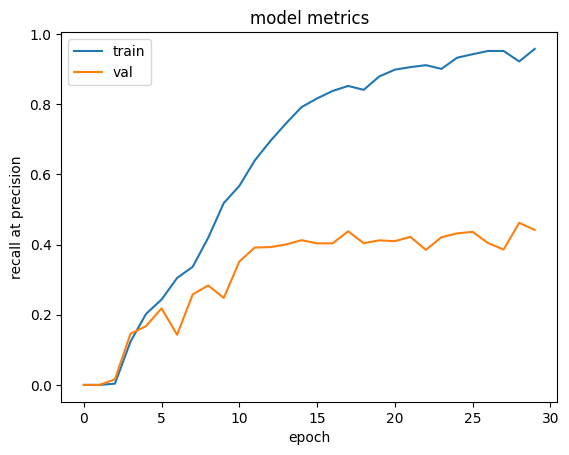

In [151]:
regular_model.plot()

In [152]:
pred = regular_model.predict(X_valid)

70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step


In [103]:
pred.shape

(2218, 19)

In [162]:
pred = pred.argmax(1)

In [163]:
pred

array([ 1,  3,  8, ...,  6, 18,  1])

In [154]:
y_valid

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [30]:
y_valid_for_report = np.array(tuple(map(lambda c: c.argmax(0), y_valid)))

In [31]:
y_valid_for_report

array([ 8,  6, 15, ..., 12, 15,  6])

In [28]:
from sklearn.metrics import classification_report

In [164]:
y_valid_for_report.shape, pred.shape

((2218,), (2218,))

In [165]:
print(
    classification_report(
        y_valid_for_report.reshape(-1),
        pred.reshape(-1),
        labels=list(
            id2label.keys()
        ),
        target_names=list(
            id2label.values()
        ),
        zero_division=0
    )
)

                   precision    recall  f1-score   support

  Наука и техника       0.62      0.72      0.67       160
        Экономика       0.84      0.69      0.76       239
      Бывший СССР       0.33      0.33      0.33       159
Силовые структуры       0.05      0.02      0.02        60
            Спорт       0.91      0.93      0.92       195
       Библиотека       0.00      0.00      0.00         0
           Россия       0.61      0.73      0.67       481
           Бизнес       0.14      0.09      0.11        22
   Интернет и СМИ       0.33      0.38      0.35       132
             Крым       0.00      0.00      0.00         2
    Культпросвет        0.00      0.00      0.00         1
      Путешествия       0.21      0.14      0.17        21
         Культура       0.63      0.65      0.64       159
   69-я параллель       0.00      0.00      0.00         4
         Из жизни       0.21      0.19      0.20        84
          Легпром       0.00      0.00      0.00       

#### Резы так себе, прям скажем. При этом результаты во время обучения очень хорошие. Скорее всего, имеем дело с переобучением. Наверное, стоит добавить дроп после первого рнн слоя.

In [23]:
class BidirectionalULMfit(MyShinyModel):

    def __init__(self, input_layer_dim: int, output_layer_dim: int):
        inputs = keras.layers.Input(shape=(self.MAX_LEN,))
        embeddings = keras.layers.Embedding(input_dim=input_layer_dim, output_dim=30)(inputs, )

        # layer_1 = keras.layers.Bidirectional(keras.layers.SimpleRNN(128, return_sequences=True))(embeddings)
        layer_2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
        drop = keras.layers.Dropout(0.4)(layer_2)
        layer_3 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(drop)

        avg_pool = keras.layers.GlobalAveragePooling1D()(layer_3)
        max_pool = keras.layers.GlobalMaxPooling1D()(layer_3)

        ##  layer_3[весь батч, последний временной промежуток, все фичи]
        concat = keras.layers.concatenate((layer_3[:, -1, :], avg_pool, max_pool,))

        softmax_layer = keras.layers.Dense(output_layer_dim, activation='softmax')(concat)

        self.model = keras.Model(inputs=inputs, outputs=softmax_layer)
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                keras.metrics.RecallAtPrecision(0.8, name='rec@prec')
            ]
        )

    # Без этого по памяти не пролезал
    def fit(self, X_train, X_valid, y_train, y_valid):
        self.model.fit(
            X_train,
            y_train,
            validation_data=(
                X_valid,
                y_valid
            ),
            batch_size=1000,
            epochs=30
        )

In [24]:
bidir_model = BidirectionalULMfit(len(word2id), len(label2id))

In [34]:
bidir_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 30)   │    722,790 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 256)  │    162,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 200, 256)  │    394,240 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 19)        │     14,611 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,883,373 (14.81 MB)

 Trainable params: 1,294,457 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,588,916 (9.88 MB)

In [25]:
bidir_model.fit(X_train, X_valid, y_train, y_valid)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 525ms/step - loss: 2.5726 - rec@prec: 0.0000e+00 - val_loss: 2.0303 - val_rec@prec: 0.0000e+00
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 525ms/step - loss: 1.9357 - rec@prec: 7.3752e-04 - val_loss: 1.7376 - val_rec@prec: 0.0924
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 527ms/step - loss: 1.5194 - rec@prec: 0.1370 - val_loss: 1.2750 - val_rec@prec: 0.3598
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - loss: 1.1088 - rec@prec: 0.4737 - val_loss: 1.1789 - val_rec@prec: 0.4797
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 543ms/step - loss: 0.9165 - rec@prec: 0.6233 - val_loss: 1.2537 - val_rec@prec: 0.4761
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 537ms/step - loss: 0.8321 - rec@prec: 0.6747 - val_loss: 1.2622 - val_rec@prec: 0.4910
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 593ms/step - loss: 0.7353 - rec@prec: 0.7394 - val_loss: 1.2712 - val_rec@prec: 0.4833
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 587ms/step - loss: 0.6660 - rec@prec: 0.783

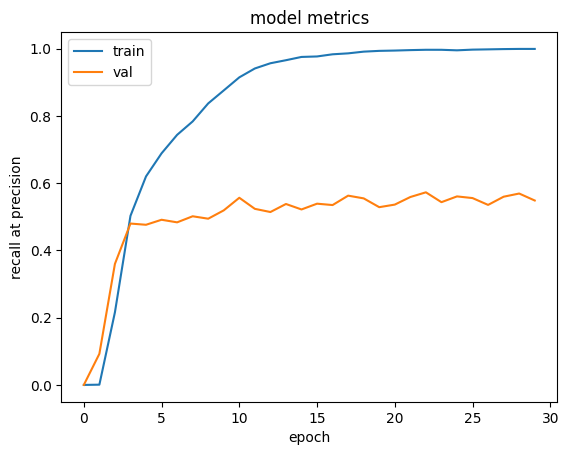

In [26]:
bidir_model.plot()

In [36]:
y_valid_for_report

array([ 8,  6, 15, ..., 12, 15,  6])

In [35]:
## Тут репорт отличается тк вылетел по памяти и пришлось перезапускать комп (куда не очищается сама)
## Впрочем, это немного странно, ведь рандом стейт обозначен.
print(
    classification_report(
        y_valid_for_report.reshape(-1),
        bidir_model.predict(X_valid).argmax(1).reshape(-1),
        labels=list(
            id2label.keys()
        ),
        target_names=list(
            id2label.values()
        ),
        zero_division=0
    )
)

70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step
                   precision    recall  f1-score   support

           Россия       0.71      0.71      0.71       481
         Из жизни       0.29      0.35      0.31        84
         Культура       0.67      0.81      0.73       159
           Бизнес       0.09      0.09      0.09        22
          Легпром       0.00      0.00      0.00         0
       Библиотека       0.00      0.00      0.00         0
              Мир       0.71      0.72      0.71       410
      Путешествия       0.12      0.10      0.11        21
      Бывший СССР       0.63      0.62      0.62       159
    Культпросвет        0.00      0.00      0.00         1
   Интернет и СМИ       0.49      0.49      0.49       132
             Крым       0.00      0.00      0.00         2
            Спорт       0.94      0.93      0.93       195
Силовые структуры       0.38      0.30      0.34        60
   69-я параллель       0.00      0.00      0.00         4
        Эконо

#### Ну вот, стало лучше. Впрочем, результаты все еще так себе.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM 
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать 
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.